In [8]:
import numpy as np
import pandas as pd
import xarray as xr
import nctoolkit as nc

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
nc.deep_clean()

# Produce area-weighted total monthly emitted CO2 timeseries for both datasets

In [3]:
# geoschem weights
with xr.open_dataset(
    "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
    "HEMCO_diagnostics.201409.nc"
) as ds:
    da_geoschem_gridbox_area = ds["AREA"]

with xr.open_dataarray("../data/geoschem_inputs.nc") as da:
    # convert units from kg/m^2/s to total petagrams in the given hour
    # temporal interval is hourly, conversion is 60*60=3600 (s/hr)
    # include conversion to petagrams: 3600 * 1e-12 = 3.6e-9
    da_geoschem = (
        (da * 3.6e-9 * da_geoschem_gridbox_area)
        .sum(dim=["lon", "lat"])
        .resample(time="1M")
        .sum()
    )

# monthly time series in petagrams
da_geoschem


<xarray.DataArray (time: 31)>
array([ 2.80348461,  4.49965468,  5.72127684,  5.54878513,  4.63494293,
        5.64189323,  5.20735709,  4.20221391, -0.56901603, -4.18650385,
       -4.68067976, -2.00387912,  3.19712715,  5.5297581 ,  6.2734532 ,
        5.8354361 ,  5.29659599,  5.48104423,  5.23375453,  4.11260886,
       -0.75511296, -4.87002277, -5.26113832, -2.55131856,  3.34188728,
        4.88496854,  5.82181957,  5.87855475,  4.82936114,  5.51964149,
        4.58871487])
Coordinates:
  * time     (time) datetime64[ns] 2014-09-30 2014-10-31 ... 2017-03-31

In [4]:
# get mozart grid box areas
ds = nc.open_data("../data/mozart_inputs.nc")
ds.subset(time=0)
ds.cell_area(join=False)
da_mozart_gridbox_area = ds.to_xarray()["cell_area"]

In [15]:
with xr.open_dataarray("../data/mozart_inputs.nc") as da:
    # convert units from kg/m^2/s to total petagrams in the given hour
    # temporal interval is hourly, conversion is 60*60=3600 (s/hr)
    # include conversion to petagrams: 3600 * 1e-12 = 3.6e-9
    da_mozart = (
        (da * 3.6e-9 * da_mozart_gridbox_area)
        .sum(dim=["lon", "lat"])
        .sortby("time")
        .resample(time="1M")
        .sum()
    )[:-1] # clip the last entry which is only based on a single day

# monthly time series in petagrams
da_mozart

<xarray.DataArray (time: 31)>
array([ 2.76370242,  4.49503466,  5.71574684,  5.54305735,  4.62610077,
        5.8151242 ,  5.179316  ,  4.05601531, -0.74123502, -4.25578055,
       -4.5940843 , -1.80269829,  3.32055896,  5.62249886,  6.22138844,
        5.78532379,  5.32961037,  5.25369263,  5.2264521 ,  4.10827536,
       -0.74925446, -4.85346856, -5.24971063, -2.55155795,  3.33865627,
        4.88035782,  5.81588514,  5.87096359,  4.82125032,  5.51013281,
        4.58170459])
Coordinates:
  * time     (time) datetime64[ns] 2014-09-30 2014-10-31 ... 2017-03-31

In [16]:
# compute the difference of the two time series
da_difference = da_geoschem - da_mozart

## Plot individual time series and difference

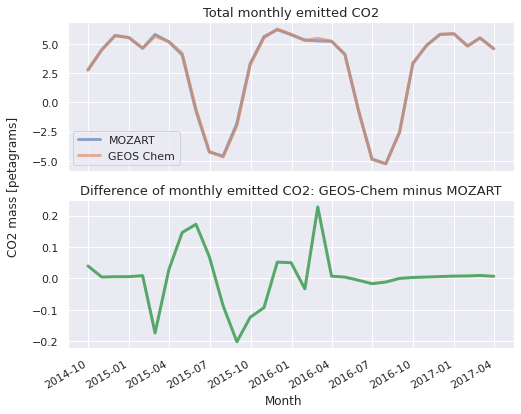

In [31]:
fig, axes = plt.subplots(2, 1, figsize=[8, 6], sharex=True)

da_mozart.plot(ax = axes[0], linewidth=3, alpha=0.6, label="MOZART")
da_geoschem.plot(ax = axes[0], linewidth=3, alpha=0.6, label="GEOS Chem")
axes[0].set_title("Total monthly emitted CO2", fontsize=13)
axes[0].set_xlabel(None)
axes[0].legend()

da_difference.plot(ax= axes[1], linewidth=3, color="#55a868")
axes[1].set_title("Difference of monthly emitted CO2: GEOS-Chem minus MOZART", fontsize=13)
axes[1].set_xlabel(None)

fig.supxlabel("Month", fontsize=12, y=-0.01)
fig.supylabel("CO2 mass [petagrams]", fontsize=12)
fig.savefig("../figures/input_timeseries.png", dpi=200);